In [1]:
import os

from tqdm import tqdm
import requests
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns; sns.set()
import pandas as pd
import json
import gdown
import scanpy as sc
import anndata as ad
from scipy import sparse

from collections import Counter
import datetime
import pickle
import gc
import subprocess
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertForSequenceClassification
from transformers import Trainer
from transformers.training_args import TrainingArguments

from geneformer import DataCollatorForCellClassification

2023-07-01 01:26:19.139697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/loompy/bus_file.py:67: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/loompy/bus_file.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behavio

Loading The huggingface dataset objects that we saved previously, along with the embeddings we obtained from raw model.

In [2]:
query_hg = load_from_disk("./query_hg/")
df_query_embd = pd.read_csv("query_embeddings.csv")

ref_hg = load_from_disk("./reference_25000/")
df_ref_embd = pd.read_csv("reference_25000_embeddings.csv")

model parameters:

In [3]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy and macro f1 using sklearn's function
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {
      'accuracy': acc,
      'macro_f1': macro_f1
    }
# set model parameters
# max input size
max_input_size = 2 ** 11  # 2048
# number gpus
num_gpus = 1
# batch size for training and eval
geneformer_batch_size = 32

In [4]:
# reload pretrained model
model = BertForSequenceClassification.from_pretrained("./trained_model/", 
                                                  num_labels=50,
                                                  output_attentions = False,
                                                  output_hidden_states = False).to("cuda")

# Map Reference

Now we pass the hg_dataset object to get new embeddings, and subsequently save them.

In [5]:
training_args = {
    "do_train": False,
    "do_eval": False,
    "evaluation_strategy": "epoch",
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
    "output_dir": "./output",
}
training_args_init = TrainingArguments(**training_args)
trainer = Trainer(
    model=model,
    args=training_args_init,
    data_collator=DataCollatorForCellClassification(),
    train_dataset=ref_hg,
    eval_dataset=ref_hg,
)
out = trainer.predict(ref_hg)

/home/amirali/anaconda3/envs/bio/lib/python3.11/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


In [8]:
to_save = pd.DataFrame(out.predictions)
to_save["index"] = df_ref_embd["index"]
to_save["label"] = df_ref_embd["label"]

to_save = to_save.set_index("index")
to_save

0         1         2         3  \
index                                                                          
TAGAGCTCAAATCCGT-1-6                 -0.412273 -1.269415  0.383147  0.913386   
TATCAGGTCGGTGTC_GRO-10_biopsy        -0.531492 -0.708998  1.886874  2.441124   
AAGGTTCTCGGCTACG_F02617              -0.298137 -0.884875  2.005899  2.472960   
CGCCAAGCACGTCTCT_F01508              -0.316979  1.608585  0.167560  0.164298   
GTACTCCTCACAGGCC_SC29                -0.880683  1.545513 -0.264871 -0.261014   
...                                        ...       ...       ...       ...   
GCTTGAAAGCTCAACT_F01511               0.273559  0.166087  2.823211  3.144814   
D354_Biop_Pro1_CTAAGACCATGCTGGC-1-20 -0.797968 -1.066766  1.308589  1.795307   
GTGCAGCTCGCAAACT_F01367               0.158158 -0.340435  2.739183  3.202886   
D344_Brus_Dis1_CGGAGTCTCGGTTAAC-1-14 -0.482379 -1.157632  0.005602  0.552030   
GACCTGGTCTAAGCCA_F02607              -0.656653  1.715656  0.043363  0.117763   

                                             4         5         6         7  \
index                                                                          
TAGAGCTCAAATCCGT-1-6                 -1.930334 -1.256757 -1.498926 -0.588548   
TATCAGGTCGGTGTC_GRO-10_biopsy        -2.306878 -1.365759 -0.714858 -0.662171   
AAGGTTCTCGGCTACG_F02617              -2.000327 -1.271130 -1.471540 -0.440145   
CGCCAAGCACGTCTCT_F01508              -1.087762 -0.991495  3.153324 -0.672725   
GTACTCCTCACAGGCC_SC29                -1.891007 -1.478867  5.298143 -0.864653   
...                                        ...       ...       ...       ...   
GCTTGAAAGCTCAACT_F01511              -1.471377 -1.203592 -0.960048 -0.238969   
D354_Biop_Pro1_CTAAGACCATGCTGGC-1-20 -2.494700 -1.284070 -0.730518 -0.751077   
GTGCAGCTCGCAAACT_F01367              -1.549997 -1.125262 -1.679556 -0.211659   
D344_Brus_Dis1_CGGAGTCTCGGTTAAC-1-14 -1.721351 -1.092270 -1.262154 -0.432198   
GACCTGGTCTAAGCCA_F02607              -1.692027 -1.349501  4.512408 -0.813271   

                                             8         9  ...        41  \
index                                                     ...             
TAGAGCTCAAATCCGT-1-6                 -0.387413 -0.356130  ... -1.160947   
TATCAGGTCGGTGTC_GRO-10_biopsy        -0.859601 -0.902379  ... -1.345703   
AAGGTTCTCGGCTACG_F02617              -0.425909 -0.899800  ... -1.130707   
CGCCAAGCACGTCTCT_F01508              -0.767836 -1.137115  ... -0.832731   
GTACTCCTCACAGGCC_SC29                -0.241285 -1.467228  ... -1.447267   
...                                        ...       ...  ...       ...   
GCTTGAAAGCTCAACT_F01511              -0.611546 -1.217408  ... -0.806919   
D354_Biop_Pro1_CTAAGACCATGCTGGC-1-20 -0.687456 -0.764212  ... -1.562185   
GTGCAGCTCGCAAACT_F01367              -0.511250 -0.999639  ... -0.800088   
D344_Brus_Dis1_CGGAGTCTCGGTTAAC-1-14 -0.081299 -0.267136  ... -1.125180   
GACCTGGTCTAAGCCA_F02607              -0.547060 -1.504284  ... -1.232718   

                                            42        43        44        45  \
index                                                                          
TAGAGCTCAAATCCGT-1-6                 -1.652312 -1.741474 -0.903980 -1.043417   
TATCAGGTCGGTGTC_GRO-10_biopsy        -2.033487 -2.209416 -1.564980 -1.240039   
AAGGTTCTCGGCTACG_F02617              -2.029747 -2.037132 -1.420970 -1.132668   
CGCCAAGCACGTCTCT_F01508              -0.903773 -1.270105 -1.163338 -0.818389   
GTACTCCTCACAGGCC_SC29                -1.474480 -2.085195 -1.915536 -1.412078   
...                                        ...       ...       ...       ...   
GCTTGAAAGCTCAACT_F01511              -1.995116 -1.560895 -1.624353 -0.501845   
D354_Biop_Pro1_CTAAGACCATGCTGGC-1-20 -1.994529 -2.336065 -1.432251 -1.449875   
GTGCAGCTCGCAAACT_F01367              -1.999490 -1.569462 -1.412841 -0.598649   
D344_Brus_Dis1_CGGAGTCTCGGTTAAC-1-14 -1.390539 -1.653692 -0.711100 -0.955838   
GACCTGGTCTAAGCCA_F02607    

In [9]:
to_save.to_csv(f"reference_25000_embeddings_finetuned.csv")

# Map Query

Repeating the procedure above:

In [11]:
training_args = {
    "do_train": False,
    "do_eval": False,
    "evaluation_strategy": "epoch",
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
    "output_dir": "./output",
}
training_args_init = TrainingArguments(**training_args)
trainer = Trainer(
    model=model,
    args=training_args_init,
    data_collator=DataCollatorForCellClassification(),
    train_dataset=query_hg,
    eval_dataset=query_hg,
)
out = trainer.predict(query_hg)

/home/amirali/anaconda3/envs/bio/lib/python3.11/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


In [13]:
to_save = pd.DataFrame(out.predictions)
to_save["index"] = df_query_embd["index"]
to_save["label"] = df_query_embd["label"]

to_save = to_save.set_index("index")
to_save

0         1         2         3         4  \
index                                                                  
GGTGTCGTCCACCTCA-1 -0.056081 -0.438322  0.372064  0.460988 -0.548202   
CATTCCGGTCGAACGA-1 -0.752491 -1.026947 -0.982953 -0.527717 -1.364356   
TCACAAGAGACAGCGT-1 -0.119817 -0.541691  0.167374  0.231269 -0.413147   
AGAGAATAGAAGCTGC-1 -0.163958 -0.492706 -0.040588 -0.026754 -0.565036   
ACACAGTAGGCCATAG-1 -0.128963 -0.467413  0.140991  0.173857 -0.653136   
...                      ...       ...       ...       ...       ...   
CTATCTAAGGTTGGAC-1 -0.651191 -0.730669  1.725961  2.250552 -2.427789   
CATCCCACATACAGAA-1 -0.655063 -0.880239  1.652507  2.143661 -2.426373   
TCGATTTAGTAATACG-1 -0.713605 -0.849744  1.563833  2.080859 -2.491646   
TGGTAGTCAGAACATA-1 -0.651191 -0.730669  1.725961  2.250552 -2.427789   
TAGTGCATCAAGTTGC-1 -0.651191 -0.730669  1.725961  2.250552 -2.427789   

                           5         6         7         8         9  ...  \
index                                                                 ...   
GGTGTCGTCCACCTCA-1 -0.334051 -1.393651  0.566053  1.614899 -0.413553  ...   
CATTCCGGTCGAACGA-1 -0.807673 -0.545321 -0.395604  0.640786 -0.170253  ...   
TCACAAGAGACAGCGT-1 -0.193164 -1.376483  0.625199  1.721751 -0.205519  ...   
AGAGAATAGAAGCTGC-1 -0.329195 -1.125592  0.612889  2.034092 -0.328287  ...   
ACACAGTAGGCCATAG-1 -0.414920 -1.173659  0.590128  1.946464 -0.467225  ...   
...                      ...       ...       ...       ...       ...  ...   
CTATCTAAGGTTGGAC-1 -1.354752 -0.515917 -0.670177 -0.772146 -0.922892  ...   
CATCCCACATACAGAA-1 -1.328506 -0.700809 -0.664378 -0.690745 -0.887286  ...   
TCGATTTAGTAATACG-1 -1.334273 -0.533402 -0.706973 -0.744361 -0.890843  ...   
TGGTAGTCAGAACATA-1 -1.354752 -0.515917 -0.670177 -0.772146 -0.922892  ...   
TAGTGCATCAAGTTGC-1 -1.354752 -0.515917 -0.670177 -0.772146 -0.922892  ...   

                          41        42        43        44        45  \
index                                                                  
GGTGTCGTCCACCTCA-1 -0.445368 -0.905184 -0.602019 -0.484119 -0.421167   
CATTCCGGTCGAACGA-1 -0.991824 -0.893324 -1.275539 -0.570255 -1.075808   
TCACAAGAGACAGCGT-1 -0.429381 -0.732627 -0.475296 -0.256416 -0.357040   
AGAGAATAGAAGCTGC-1 -0.443765 -0.805988 -0.555534 -0.437463 -0.493556   
ACACAGTAGGCCATAG-1 -0.505518 -0.944400 -0.728889 -0.583019 -0.560215   
...                      ...       ...       ...       ...       ...   
CTATCTAAGGTTGGAC-1 -1.444640 -2.057389 -2.293192 -1.602287 -1.329333   
CATCCCACATACAGAA-1 -1.432472 -2.056861 -2.301530 -1.559139 -1.342803   
TCGATTTAGTAATACG-1 -1.490428 -2.051885 -2.337419 -1.570205 -1.370131   
TGGTAGTCAGAACATA-1 -1.444640 -2.057389 -2.293192 -1.602287 -1.329333   
TAGTGCATCAAGTTGC-1 -1.444640 -2.057389 -2.293192 -1.602287 -1.329333   

                          46        47        48        49    label  
index                                                                
GGTGTCGTCCACCTCA-1  0.012578  0.551595 -0.332036  1.339422  Unknown  
CATTCCGGTCGAACGA-1 -0.942598 -0.184568  0.421860  0.136857  Unknown  
TCACAAGAGACAGCGT-1  0.020484  0.378567 -0.690795  1.177580  Unknown  
AGAGAATAGAAGCTGC-1 -0.002700  0.503772  0.437068  1.152402  Unknown  
ACACAGTAGGCCATAG-1 -0.063567  0.556469  0.707968  1.179250  Unknown  
...                      ...       ...       ...       ...      ...  
CTATCTAAGGTTGGAC-1 -1.005575 -0.365193  0.013646  0.202400  Unknown  
CATCCCACATACAGAA-1 -0.991185 -0.335969  0.081423  0.215477  Unknown  
TCGATTTAGTAATACG-1 -1.055580 -0.405893  0.076455  0.122419  Unknown  
TGGTAGTCAGAACATA-1 -1.005575 -0.365193  0.013646  0.202400  Unknown  
TAGTGCATCAAGTTGC-1 -1.005575 -0.365193  0.013646  0.202400  Unknown  

[2142 rows x 51 columns]

In [14]:
to_save.to_csv(f"query_embeddings_finetuned.csv")

# Training a Classifier

We train a new classifier using the new embeddings obtained from fine-tuned model. Similar to what we did previously.

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
df_query_embd = pd.read_csv("query_embeddings_finetuned.csv")
df_query_embd.head(1)

index         0         1         2         3         4  \
0  GGTGTCGTCCACCTCA-1 -0.056081 -0.438322  0.372064  0.460988 -0.548202   

          5         6         7         8  ...        41        42        43  \
0 -0.334051 -1.393651  0.566053  1.614899  ... -0.445368 -0.905184 -0.602019   

         44        45        46        47        48        49    label  
0 -0.484119 -0.421167  0.012578  0.551595 -0.332036  1.339422  Unknown  

[1 rows x 52 columns]

In [4]:
df_ref_embd = pd.read_csv("reference_25000_embeddings_finetuned.csv")
df_ref_embd.head(1)

index         0         1         2         3         4  \
0  TAGAGCTCAAATCCGT-1-6 -0.412273 -1.269415  0.383147  0.913386 -1.930334   

          5         6         7         8  ...        41        42        43  \
0 -1.256757 -1.498926 -0.588549 -0.387413  ... -1.160947 -1.652312 -1.741474   

        44        45      46        47        48        49      label  
0 -0.90398 -1.043417 -0.8952  0.062345  0.813687  0.289818  club cell  

[1 rows x 52 columns]

In [5]:
le = preprocessing.LabelEncoder()
le.fit(df_ref_embd["label"])
X = df_ref_embd.drop(["label", "index"], axis=1)
y = le.transform(df_ref_embd["label"])

In [6]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.15)

In [7]:
classifier = models.Sequential([
    tf.keras.layers.Dense(64, activation = tf.nn.relu),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(256, activation = tf.nn.relu),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(64, activation = tf.nn.relu),
    tf.keras.layers.Dense(50, activation = tf.nn.softmax)
])

classifier.compile(
    optimizer = optimizers.legacy.Adam(learning_rate=0.0005),
    loss = 'sparse_categorical_crossentropy',
    metrics =['accuracy']
)

In [8]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = classifier.fit(
    X_train, 
    y_train,
    epochs = 500,
    batch_size = 16,
    validation_split = 0.2,
    verbose=1,
    callbacks=[earlystopping]
)

Epoch 1/500
1063/1063 [==============================] - 11s 9ms/step - loss: 1.5552 - accuracy: 0.5406 - val_loss: 1.3244 - val_accuracy: 0.5864
Epoch 2/500
1063/1063 [==============================] - 9s 9ms/step - loss: 1.2967 - accuracy: 0.5949 - val_loss: 1.2414 - val_accuracy: 0.6054
Epoch 3/500
1063/1063 [==============================] - 9s 9ms/step - loss: 1.2601 - accuracy: 0.5976 - val_loss: 1.2252 - val_accuracy: 0.6085
Epoch 4/500
1063/1063 [==============================] - 9s 9ms/step - loss: 1.2302 - accuracy: 0.6035 - val_loss: 1.2029 - val_accuracy: 0.6155
Epoch 5/500
1063/1063 [==============================] - 9s 9ms/step - loss: 1.2131 - accuracy: 0.6078 - val_loss: 1.2010 - val_accuracy: 0.6184
Epoch 6/500
1063/1063 [==============================] - 9s 9ms/step - loss: 1.1998 - accuracy: 0.6052 - val_loss: 1.2202 - val_accuracy: 0.6049
Epoch 7/500
1063/1063 [==============================] - 9s 9ms/step - loss: 1.1930 - accuracy: 0.6102 - val_loss: 1.1851 - val_a

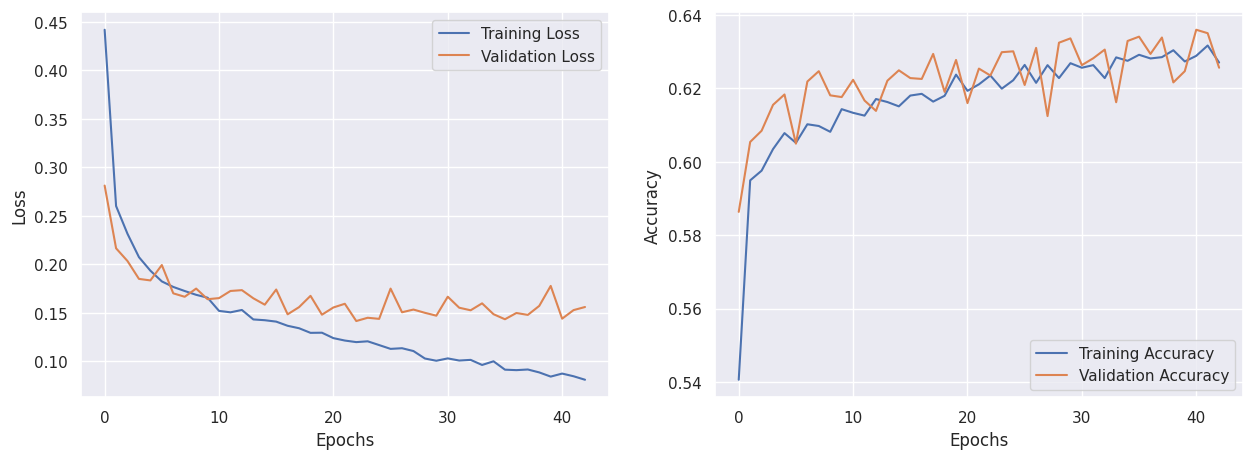

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].plot(np.log(history.history["loss"]), label="Training Loss")
axs[0].plot(np.log(history.history["val_loss"]), label="Validation Loss")
axs[0].legend()

axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].plot(history.history["accuracy"], label="Training Accuracy")
axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
axs[1].legend()

In [11]:
# classifier.save("classifier_finetuned.keras")

In [ ]:
# classifier = tf.keras.saving.load_model("classifier.keras")

Now we pass the query embeddings to the classifier.

In [12]:
X_query = df_query_embd.drop(["label", "index"], axis=1)
X_query.head(1)

0         1         2         3         4         5         6  \
0 -0.056081 -0.438322  0.372064  0.460988 -0.548202 -0.334051 -1.393651   

          7         8         9  ...        40        41        42        43  \
0  0.566053  1.614899 -0.413553  ... -0.370401 -0.445368 -0.905184 -0.602019   

         44        45        46        47        48        49  
0 -0.484119 -0.421167  0.012578  0.551595 -0.332036  1.339422  

[1 rows x 50 columns]

In [13]:
df_query_embd["gt"] = df_query_embd["label"]
df_query_embd["label"] = np.argmax(classifier.predict(X_query), axis=1)
df_query_embd["label"] = le.inverse_transform(df_query_embd["label"])
df_query_embd

67/67 [==============================] - 0s 3ms/step


index         0         1         2         3         4  \
0     GGTGTCGTCCACCTCA-1 -0.056081 -0.438322  0.372064  0.460988 -0.548202   
1     CATTCCGGTCGAACGA-1 -0.752491 -1.026946 -0.982953 -0.527717 -1.364356   
2     TCACAAGAGACAGCGT-1 -0.119817 -0.541691  0.167374  0.231269 -0.413147   
3     AGAGAATAGAAGCTGC-1 -0.163958 -0.492706 -0.040588 -0.026754 -0.565036   
4     ACACAGTAGGCCATAG-1 -0.128963 -0.467413  0.140991  0.173857 -0.653136   
...                  ...       ...       ...       ...       ...       ...   
2137  CTATCTAAGGTTGGAC-1 -0.651191 -0.730669  1.725961  2.250552 -2.427789   
2138  CATCCCACATACAGAA-1 -0.655063 -0.880239  1.652507  2.143661 -2.426372   
2139  TCGATTTAGTAATACG-1 -0.713604 -0.849744  1.563833  2.080859 -2.491646   
2140  TGGTAGTCAGAACATA-1 -0.651191 -0.730669  1.725961  2.250552 -2.427789   
2141  TAGTGCATCAAGTTGC-1 -0.651191 -0.730669  1.725961  2.250552 -2.427789   

             5         6         7         8  ...        42        43  \
0    -0.334051 -1.393651  0.566053  1.614899  ... -0.905184 -0.602019   
1    -0.807673 -0.545321 -0.395604  0.640786  ... -0.893324 -1.275539   
2    -0.193164 -1.376483  0.625199  1.721751  ... -0.732627 -0.475296   
3    -0.329195 -1.125592  0.612889  2.034092  ... -0.805988 -0.555534   
4    -0.414920 -1.173659  0.590128  1.946464  ... -0.944400 -0.728889   
...        ...       ...       ...       ...  ...       ...       ...   
2137 -1.354752 -0.515917 -0.670177 -0.772146  ... -2.057389 -2.293192   
2138 -1.328506 -0.700809 -0.664378 -0.690745  ... -2.056861 -2.301530   
2139 -1.334273 -0.533402 -0.706973 -0.744361  ... -2.051885 -2.337419   
2140 -1.354752 -0.515917 -0.670177 -0.772146  ... -2.057389 -2.293192   
2141 -1.354752 -0.515917 -0.670177 -0.772146  ... -2.057389 -2.293192   

            44        45        46        47        48        49  \
0    -0.484119 -0.421167  0.012578  0.551595 -0.332036  1.339422   
1    -0.570255 -1.075808 -0.942598 -0.184568  0.421860  0.136857   
2    -0.256416 -0.357040  0.020484  0.378567 -0.690794  1.177580   
3    -0.437463 -0.493556 -0.002700  0.503772  0.437068  1.152402   
4    -0.583019 -0.560215 -0.063567  0.556469  0.707968  1.179250   
...        ...       ...       ...       ...       ...       ...   
2137 -1.602287 -1.329333 -1.005575 -0.365193  0.013646  0.202400   
2138 -1.559139 -1.342803 -0.991185 -0.335969  0.081423  0.215477   
2139 -1.570205 -1.370131 -1.055581 -0.405893  0.076455  0.122419   
2140 -1.602287 -1.329333 -1.005575 -0.365193  0.013646  0.202400   
2141 -1.602287 -1.329333 -1.005575 -0.365193  0.013646  0.202400   

                                                label       gt  
0                                       lung pericyte  Unknown  
1     ciliated columnar cell of tracheobronchial tree  Unknown  
2                         bronchus fibroblast of lung  Unknown  
3                     alveolar type 2 fibroblast cell  Unknown  
4                     alveolar type 2 fibroblast cell  Unknown  
...                                               ...      ...  
2137                  CD8-positive, alpha-beta T cell  Unknown  
2138                           respiratory basal cell  Unknown  
2139                           respiratory basal cell  Unknown  
2140                  CD8-positive, alpha-beta T cell  Unknown  
2141                  CD8-positive, alpha-beta T cell  Unknown  

[2142 rows x 53 columns]

## Comparing Label with Ground Truth

We want to know what are the most frequent (predicted, ground-truth) pairs for each ground-truth label.

In [25]:
label_gt = df_query_embd[df_query_embd["gt"]!="Unknown"][["label", "gt"]]
label_gt

label             gt
18    alveolar type 2 fibroblast cell     hepatocyte
21    alveolar type 2 fibroblast cell     hepatocyte
71                elicited macrophage     macrophage
82             respiratory basal cell  cholangiocyte
90    alveolar type 1 fibroblast cell     macrophage
...                               ...            ...
2124           respiratory basal cell     macrophage
2125           respiratory basal cell     hepatocyte
2126           respiratory basal cell     macrophage
2127           respiratory basal cell     fibroblast
2130           respiratory basal cell            nkt

[482 rows x 2 columns]

In [37]:
gt_uniques = label_gt['gt'].unique()
the_most_similar_pairs = {}
for gt in gt_uniques:
    the_most_similar_pairs[gt] = label_gt[label_gt["gt"]==gt]["label"].mode()[0]

Using the trained classifier now we can say that each cell types in query is similar to which cell type in reference.

In [42]:
the_most_similar_pairs

{'hepatocyte': 'respiratory basal cell',
 'macrophage': 'respiratory basal cell',
 'cholangiocyte': 'CD8-positive, alpha-beta T cell',
 'fibroblast': 'respiratory basal cell',
 'vascular endothelial': 'respiratory basal cell',
 'mesothelial': 'nasal mucosa goblet cell',
 'CD16+ monocyte': 'mast cell',
 'monocyte': 'mast cell',
 'myofibroblast': 'CD8-positive, alpha-beta T cell',
 'nk': 'vein endothelial cell',
 'neutrophil': 'CD8-positive, alpha-beta T cell',
 'lymphatic endothelial': 'B cell',
 'plasma': 'respiratory basal cell',
 'b': 'respiratory basal cell',
 'nkt': 'respiratory basal cell'}

# Plotting

Now we want to plot the UMAP of embeddings obtained from fine-tuned model.

In [43]:
df_merged = df_ref_embd.copy()
df_merged["is_ref"] = True

df_merged = pd.concat([df_merged, df_query_embd.drop(["gt"], axis=1)], axis=0)
df_merged["is_ref"] = df_merged["is_ref"].fillna(False)
df_merged = df_merged.reset_index(drop=True)
df_merged

index         0         1         2         3  \
0               TAGAGCTCAAATCCGT-1-6 -0.412273 -1.269415  0.383147  0.913386   
1      TATCAGGTCGGTGTC_GRO-10_biopsy -0.531493 -0.708998  1.886874  2.441124   
2            AAGGTTCTCGGCTACG_F02617 -0.298137 -0.884875  2.005899  2.472960   
3            CGCCAAGCACGTCTCT_F01508 -0.316979  1.608586  0.167560  0.164298   
4              GTACTCCTCACAGGCC_SC29 -0.880683  1.545513 -0.264871 -0.261014   
...                              ...       ...       ...       ...       ...   
27137             CTATCTAAGGTTGGAC-1 -0.651191 -0.730669  1.725961  2.250552   
27138             CATCCCACATACAGAA-1 -0.655063 -0.880239  1.652507  2.143661   
27139             TCGATTTAGTAATACG-1 -0.713604 -0.849744  1.563833  2.080859   
27140             TGGTAGTCAGAACATA-1 -0.651191 -0.730669  1.725961  2.250552   
27141             TAGTGCATCAAGTTGC-1 -0.651191 -0.730669  1.725961  2.250552   

              4         5         6         7         8  ...        42  \
0     -1.930334 -1.256757 -1.498926 -0.588549 -0.387413  ... -1.652312   
1     -2.306878 -1.365759 -0.714858 -0.662170 -0.859601  ... -2.033487   
2     -2.000327 -1.271130 -1.471540 -0.440145 -0.425909  ... -2.029747   
3     -1.087762 -0.991495  3.153324 -0.672725 -0.767836  ... -0.903773   
4     -1.891007 -1.478867  5.298143 -0.864653 -0.241285  ... -1.474480   
...         ...       ...       ...       ...       ...  ...       ...   
27137 -2.427789 -1.354752 -0.515917 -0.670177 -0.772146  ... -2.057389   
27138 -2.426372 -1.328506 -0.700809 -0.664378 -0.690745  ... -2.056861   
27139 -2.491646 -1.334273 -0.533402 -0.706973 -0.744361  ... -2.051885   
27140 -2.427789 -1.354752 -0.515917 -0.670177 -0.772146  ... -2.057389   
27141 -2.427789 -1.354752 -0.515917 -0.670177 -0.772146  ... -2.057389   

             43        44        45        46        47        48        49  \
0     -1.741474 -0.903980 -1.043417 -0.895200  0.062345  0.813687  0.289818   
1     -2.209416 -1.564980 -1.240039 -0.930008 -0.254200 -0.015916  0.289179   
2     -2.037132 -1.420970 -1.132668 -0.687373  0.098229  0.037873  0.728230   
3     -1.270105 -1.163338 -0.818389 -0.822105 -0.287954 -0.264682 -0.304439   
4     -2.085195 -1.915536 -1.412078 -1.290408 -0.505268  0.965984 -0.694172   
...         ...       ...       ...       ...       ...       ...       ...   
27137 -2.293192 -1.602287 -1.329333 -1.005575 -0.365193  0.013646  0.202400   
27138 -2.301530 -1.559139 -1.342803 -0.991185 -0.335969  0.081423  0.215477   
27139 -2.337419 -1.570205 -1.370131 -1.055581 -0.405893  0.076455  0.122419   
27140 -2.293192 -1.602287 -1.329333 -1.005575 -0.365193  0.013646  0.202400   
27141 -2.293192 -1.602287 -1.329333 -1.005575 -0.365193  0.013646  0.202400   

                                 label  is_ref  
0                            club cell    True  
1      CD4-positive, alpha-beta T cell    True  
2                   type II pneumocyte    True  
3                  elicited macrophage    True  
4                  alveolar macrophage    True  
...                                ...     ...  
27137  CD8-positive, alpha-beta T cell   False  
27138           respiratory basal cell   False  
27139           respiratory basal cell   False  
27140  CD8-positive, alpha-beta T cell   False  
27141  CD8-positive, alpha-beta T cell   False  

[27142 rows x 53 columns]

In [44]:
import umap
reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(df_merged.drop(["index", "label", "is_ref"], axis=1))
umap_embedding = pd.DataFrame(umap_embedding)

In [45]:
umap_embedding["label"] = df_merged["label"]
umap_embedding["is_ref"] = df_merged["is_ref"]
umap_embedding.head(3)

0         1                            label  is_ref
0 -2.548391  8.873746                        club cell    True
1  4.146643  9.007639  CD4-positive, alpha-beta T cell    True
2  3.941565  8.298191               type II pneumocyte    True

<Axes: xlabel='1', ylabel='0'>

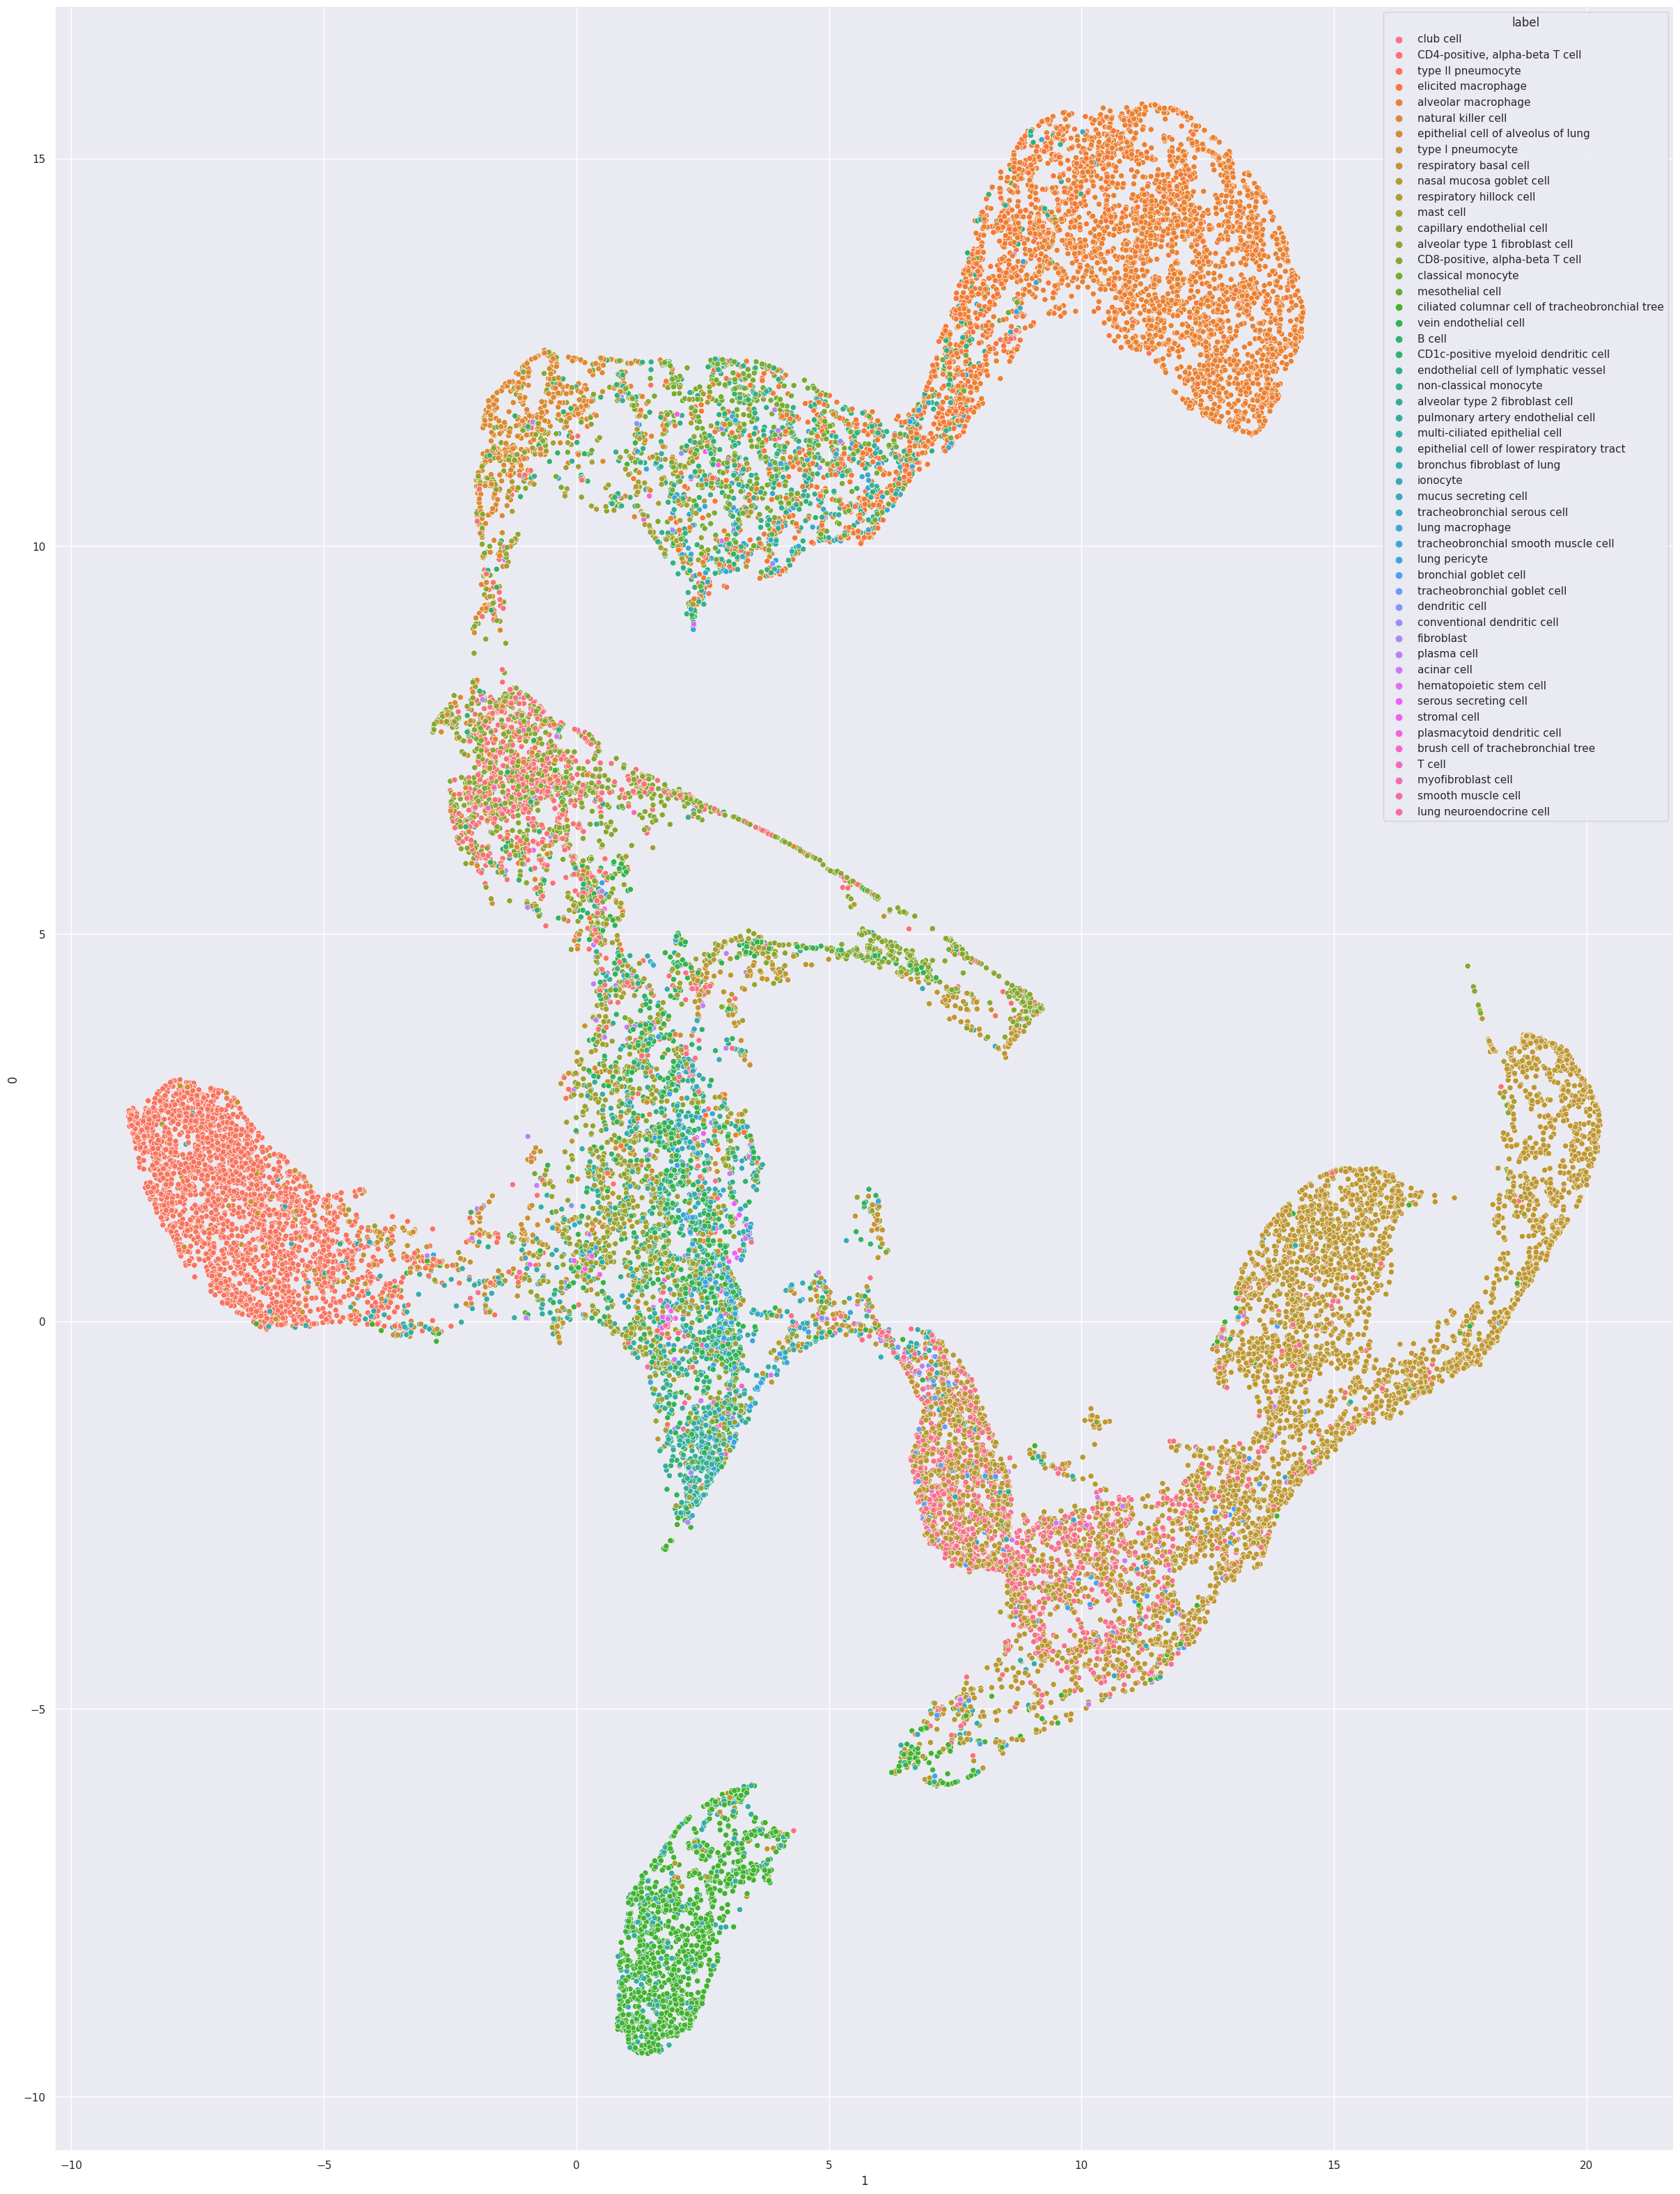

In [46]:
plt.figure(figsize=(30,40))
sns.scatterplot(
    umap_embedding,
    x=1, y=0,
    hue="label",
    legend=True,
)

The result is much better than the result we got from raw model. we can see that different cell types are making different clusters in the latent space.

<Axes: xlabel='1', ylabel='0'>

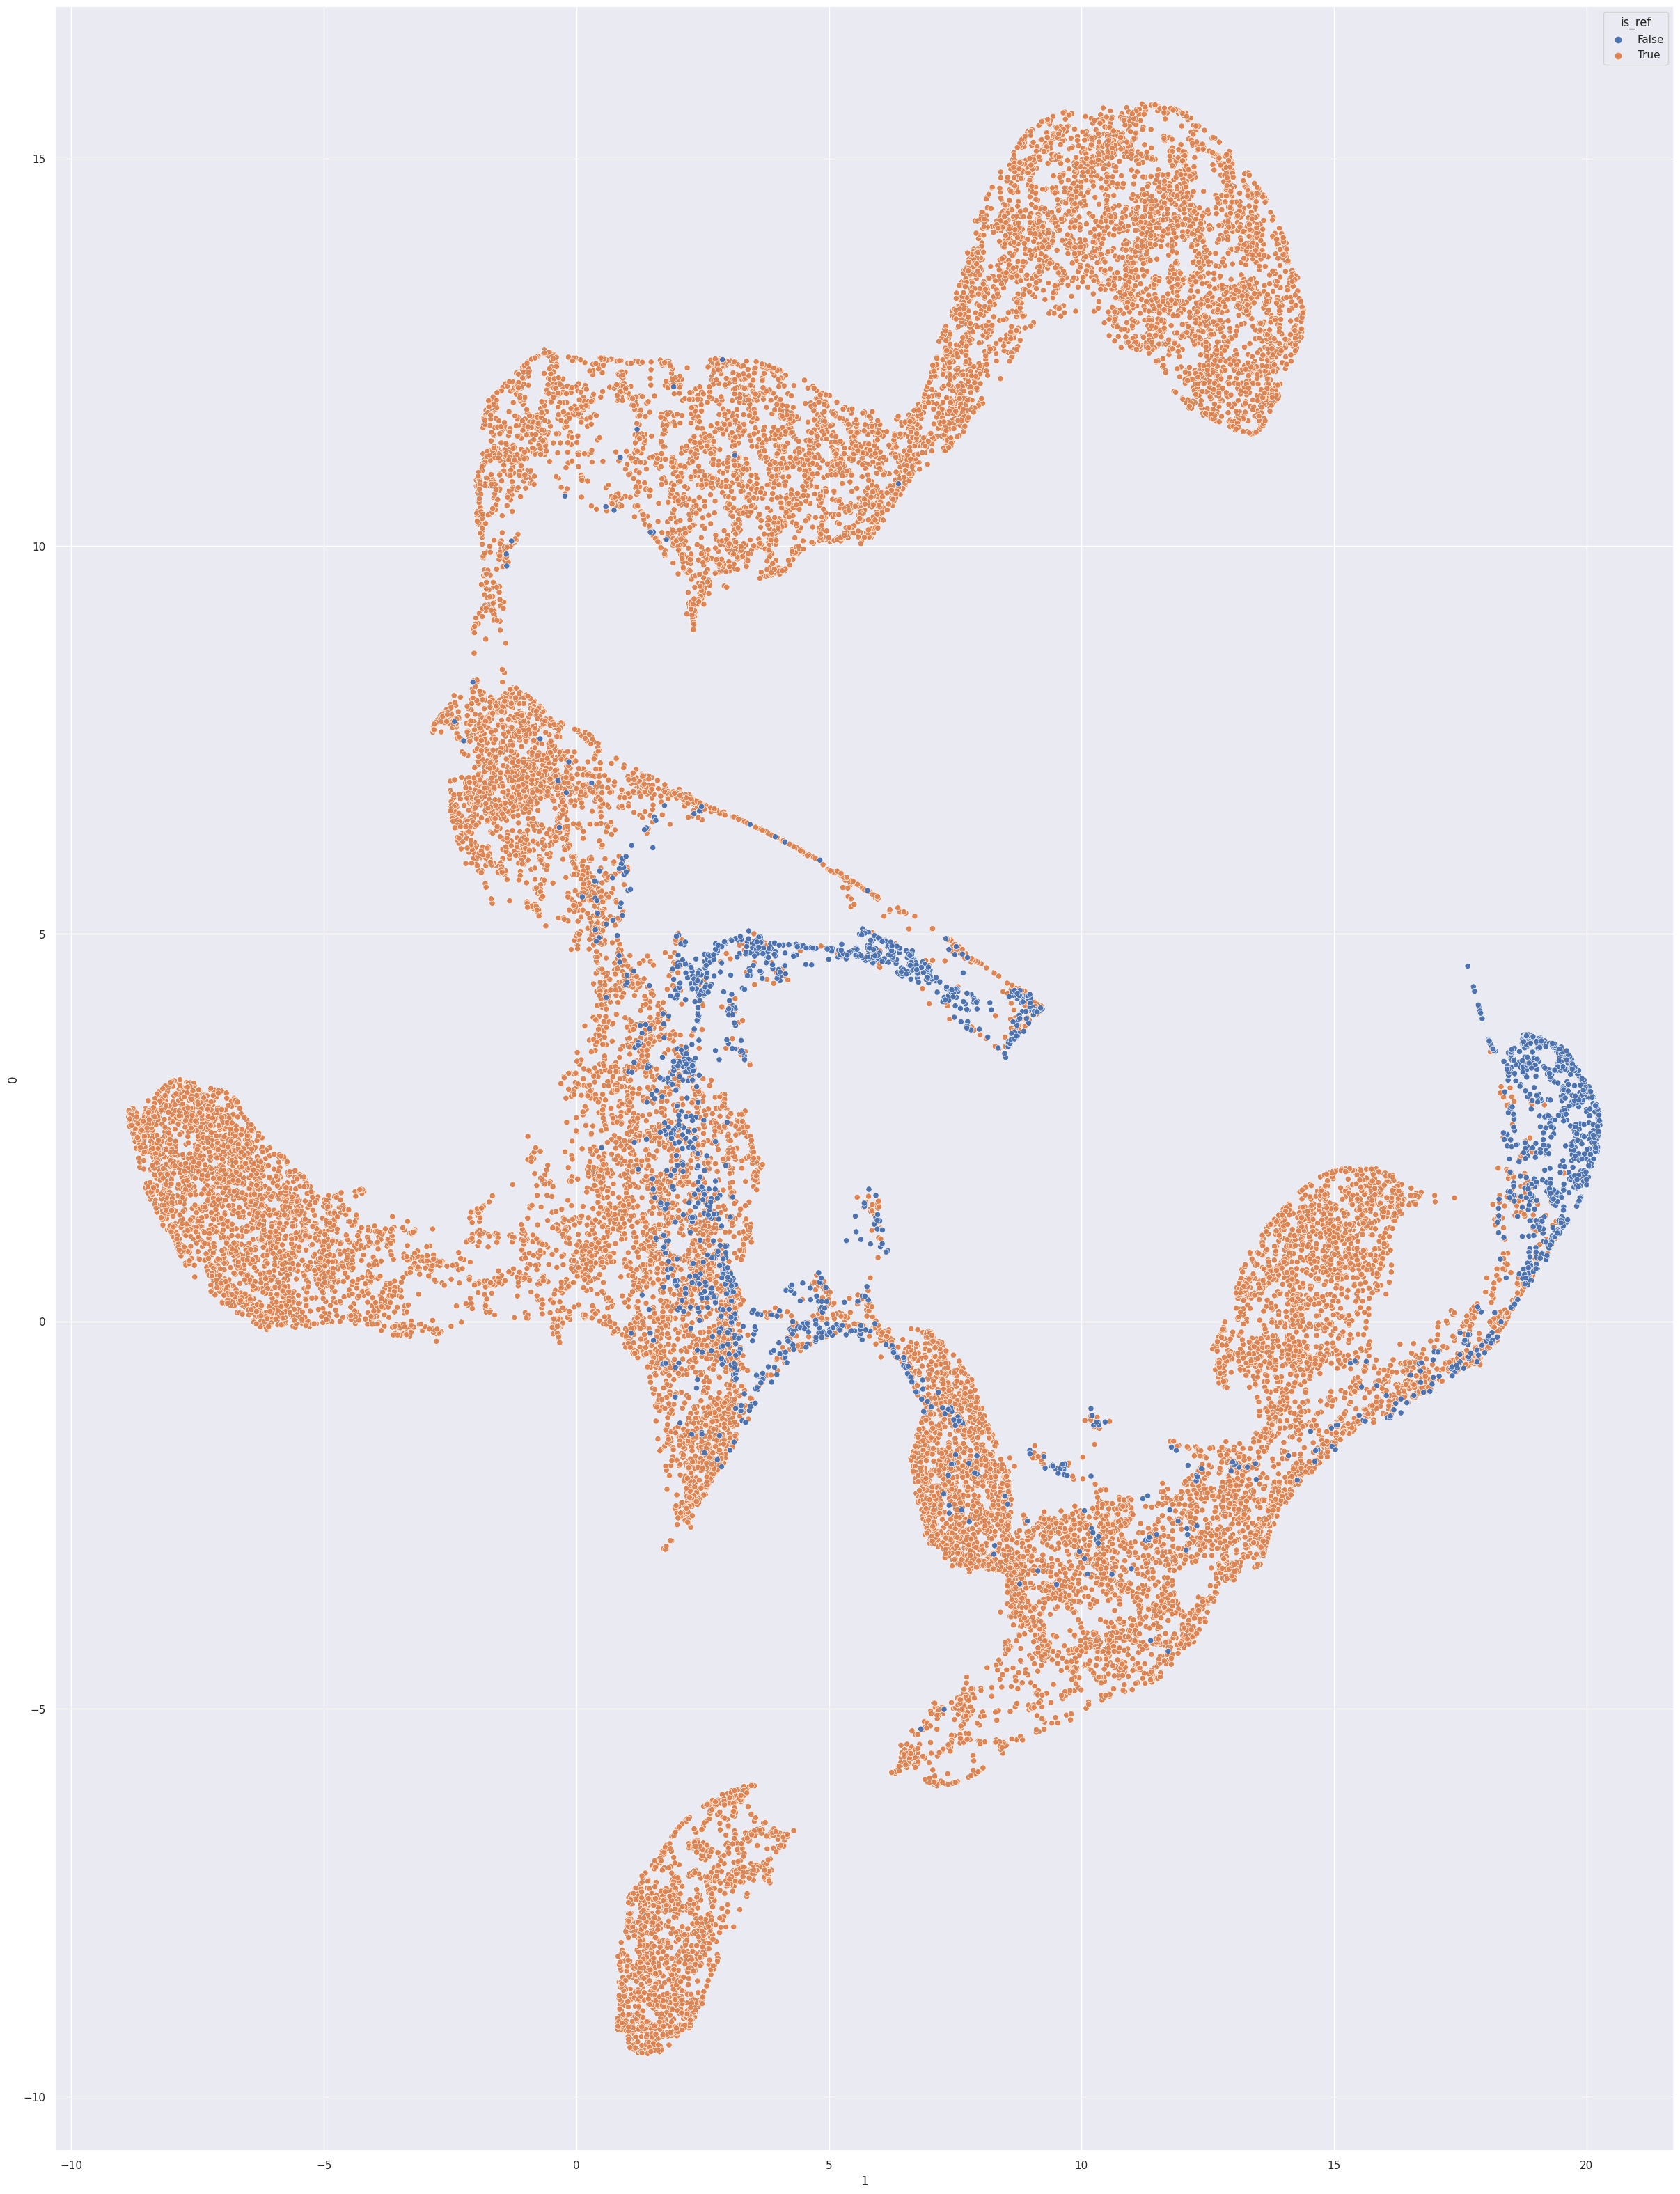

In [47]:
plt.figure(figsize=(30,40))
sns.scatterplot(
    umap_embedding,
    x=1, y=0,
    hue="is_ref",
    legend=True,
)


This result is also much better than the result we got from raw model. we can see that the model could integrate the query data into the reference model and they don't create clusters that are far from each other.

Selecting the cells which are in the_most_similar_pairs dictionary.

In [61]:
umap_embedding["is_in_dict_val"] = umap_embedding["label"].map(
    lambda x: x in set(the_most_similar_pairs.values())
)

In [87]:
umap_embedding

0          1                            label  is_ref  \
0      -2.548391   8.873746                        club cell    True   
1       4.146643   9.007639  CD4-positive, alpha-beta T cell    True   
2       3.941565   8.298191               type II pneumocyte    True   
3      10.853774   4.659252              elicited macrophage    True   
4      14.212160   8.425694              alveolar macrophage    True   
...          ...        ...                              ...     ...   
27137   4.582544  17.649195  CD8-positive, alpha-beta T cell   False   
27138   2.101358  18.793304           respiratory basal cell   False   
27139   2.399962  20.138628           respiratory basal cell   False   
27140   4.583163  17.649019  CD8-positive, alpha-beta T cell   False   
27141   4.582887  17.649237  CD8-positive, alpha-beta T cell   False   

       is_in_dict_val  
0               False  
1               False  
2               False  
3               False  
4               False  
...               ...  
27137            True  
27138            True  
27139            True  
27140            True  
27141            True  

[27142 rows x 5 columns]

In [94]:
tmp_ref, tmp_query = umap_embedding[:len(df_ref_embd)], umap_embedding[len(df_ref_embd):].copy()

In [96]:
tmp_query = tmp_query.reset_index(drop=False)
tmp_query["label"]  = df_query_embd["gt"]
tmp_query = tmp_query.set_index("index")
umap_embedding_tmp = pd.concat([tmp_ref, tmp_query], axis=0)
umap_embedding_tmp

0          1                            label  is_ref  \
0      -2.548391   8.873746                        club cell    True   
1       4.146643   9.007639  CD4-positive, alpha-beta T cell    True   
2       3.941565   8.298191               type II pneumocyte    True   
3      10.853774   4.659252              elicited macrophage    True   
4      14.212160   8.425694              alveolar macrophage    True   
...          ...        ...                              ...     ...   
27137   4.582544  17.649195                          Unknown   False   
27138   2.101358  18.793304                          Unknown   False   
27139   2.399962  20.138628                          Unknown   False   
27140   4.583163  17.649019                          Unknown   False   
27141   4.582887  17.649237                          Unknown   False   

       is_in_dict_val  
0               False  
1               False  
2               False  
3               False  
4               False  
...               ...  
27137            True  
27138            True  
27139            True  
27140            True  
27141            True  

[27142 rows x 5 columns]

<Axes: xlabel='1', ylabel='0'>

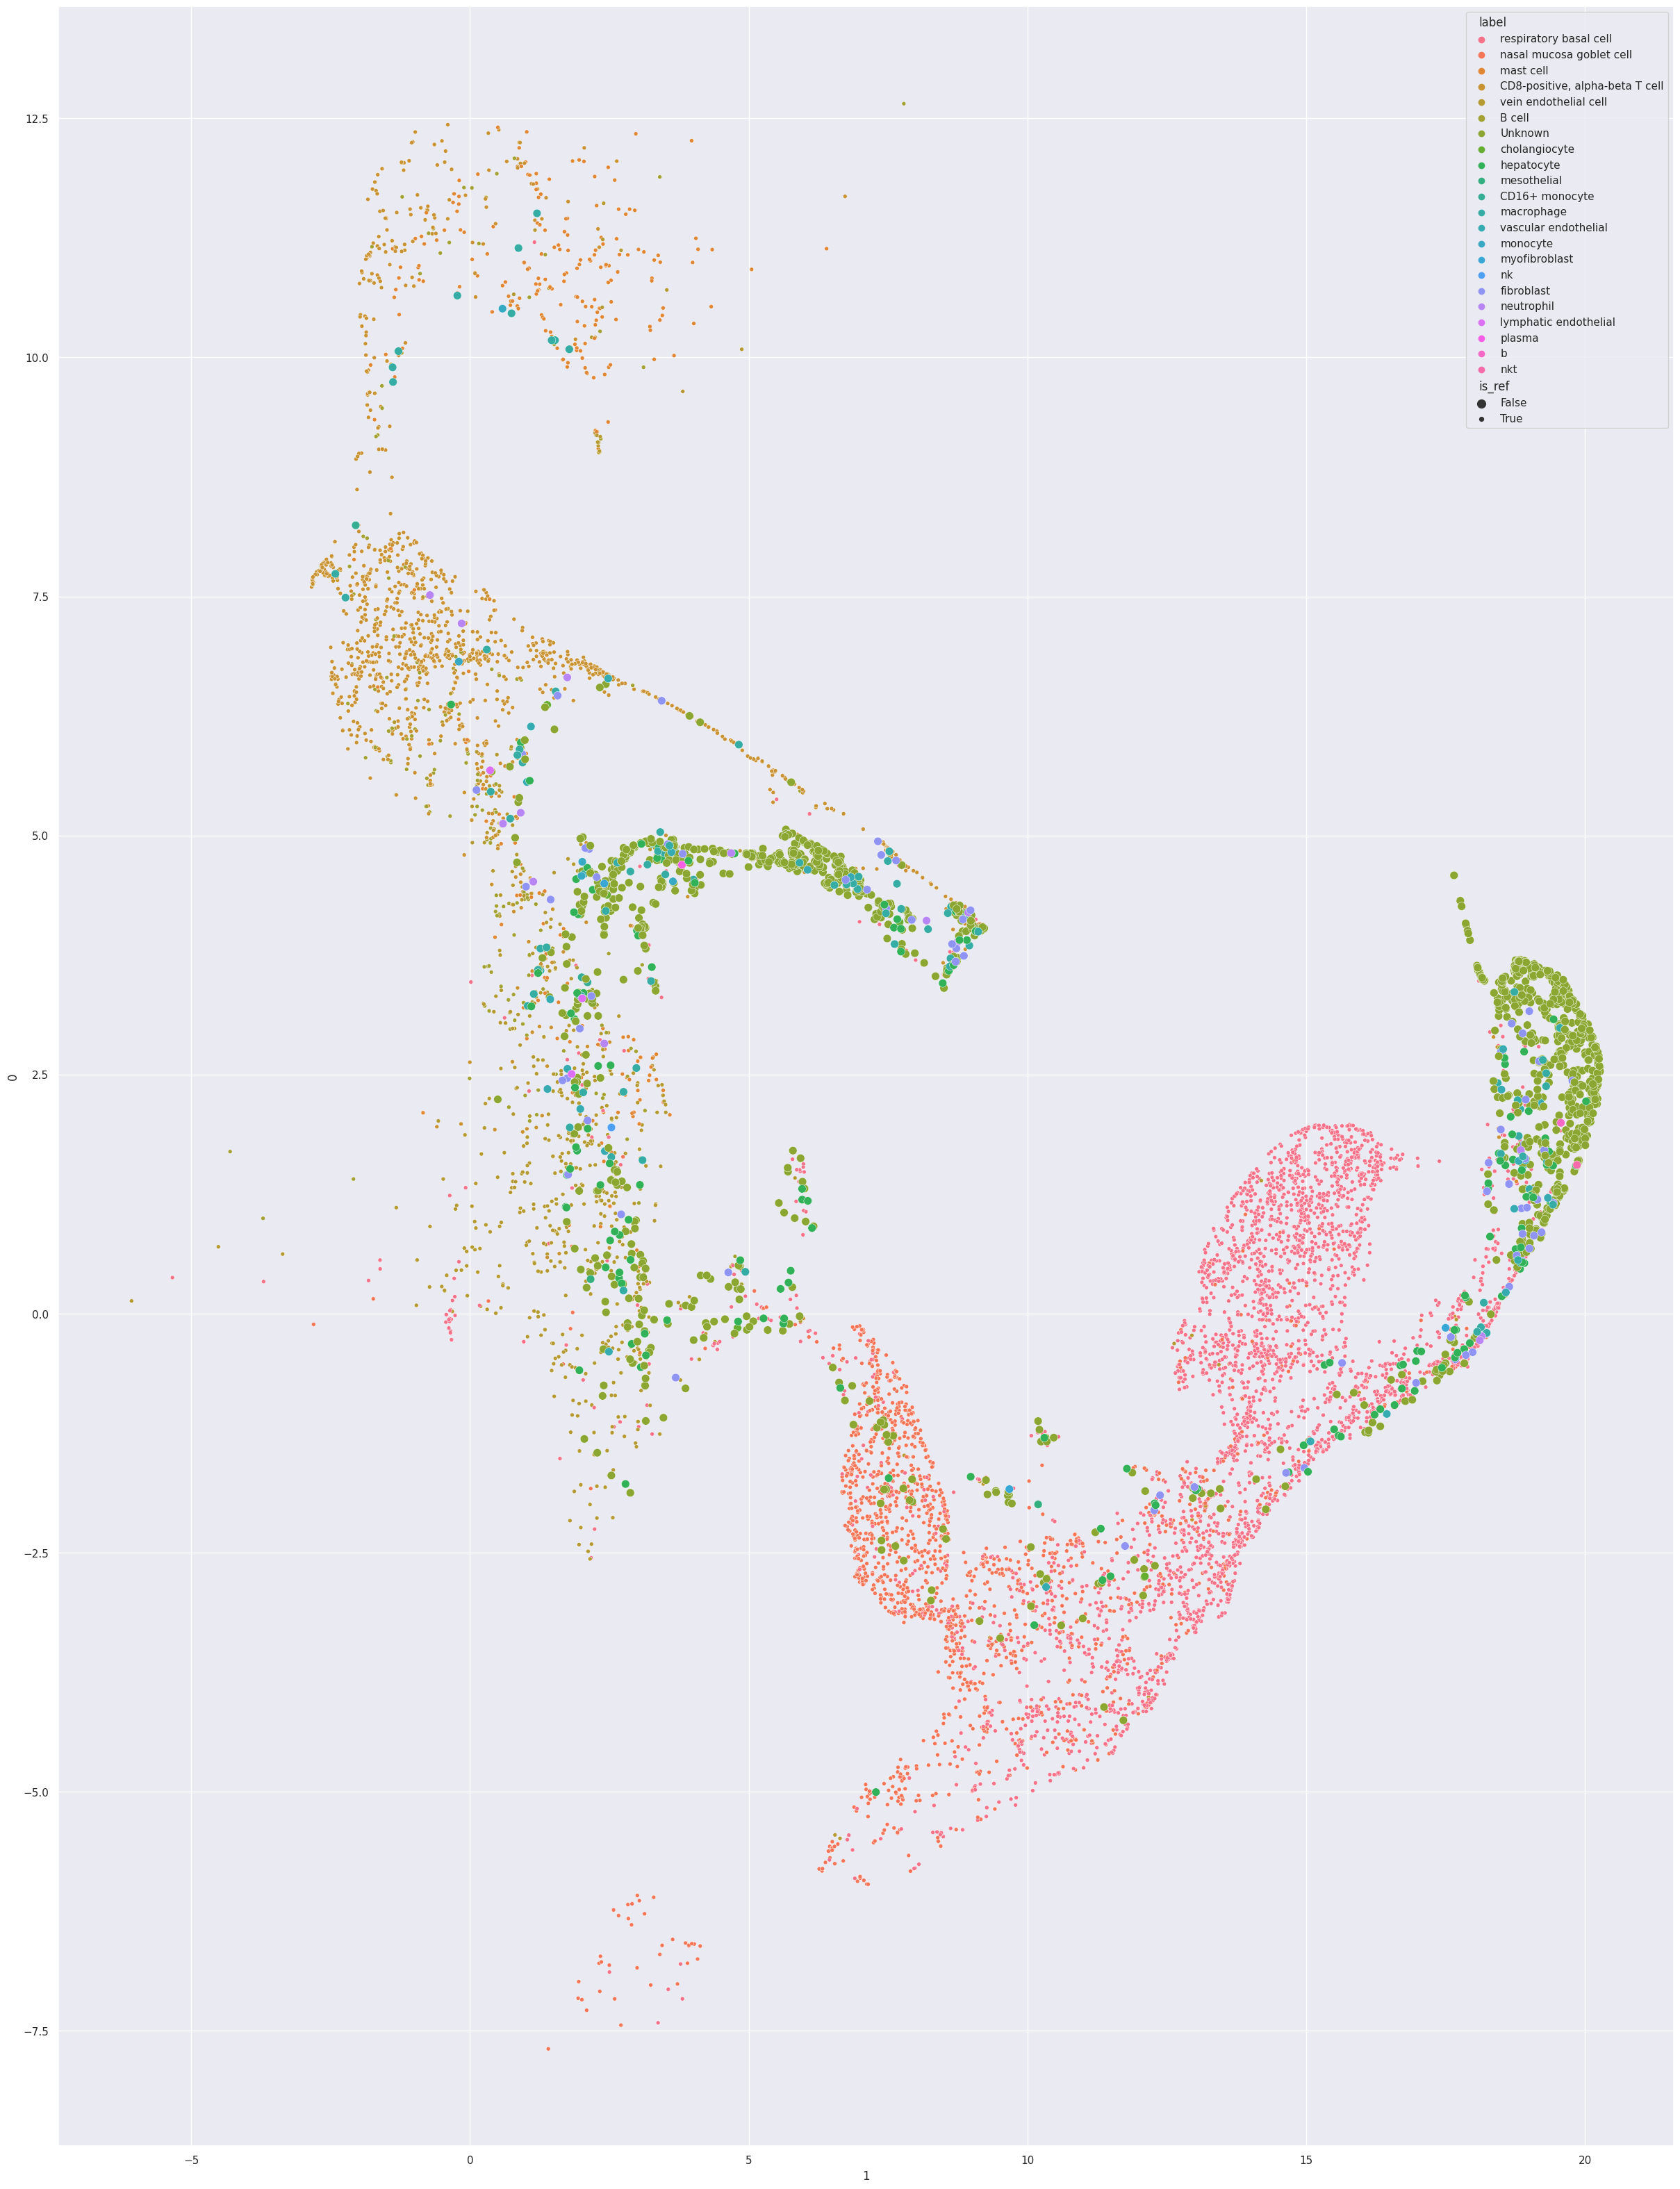

In [113]:
plt.figure(figsize=(30,40))
sns.scatterplot(
    umap_embedding_tmp[(umap_embedding_tmp["is_in_dict_val"])],
    x=1, y=0,
    hue="label",
    size="is_ref",
    legend=True,
)